# Project Milestone 3 Notebook
## Do Americans prefer beers with a higher alcohol content (ABV) than Europeans? 
- Is there a correlation between this preference and specific beer styles known for higher ABV?
We will use grouping techniques and micro/macro averages to analyse this preference.
- How have beer preferences, especially in terms of ABV, evolved in America and Europe between 2000 and 2017?
To analyse this question, we will use time series analysis and visualisation techniques.

## 1. Imports and global variables

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_gzip_txt_data

## 2. Preprocessing of the data:

#### 2.1 Load the users and split between North America and Europe:

Define European countries:

In [2]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Jersey", "Kazakhstan",
    "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta",
    "Moldova", "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia",
    "Slovakia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
    "Ukraine", "Vatican City", "Wales"
]

# /!\ Slovakia in RateBeer and Slovak Republic in BeerAdvocate /!\

Load users files and classify if European, North American or neither:

In [3]:
def get_na_or_eu(row):
    """
    In a Dataframe with a column "location", returns whether the location 
    is in Europe or North America.
    
    :param row: pandas.Dataframe row with an attribute "location".
    :return: str, can be "NA", "EU" or "Other".
    """
    location = row['location']
    if location in european_countries:
        return 'Europe'
    elif (location == 'Canada') or ("United States" in str(location)):
        return 'North America'
    else:
        return 'Other'


ba_users_df = pd.read_csv("./data/BeerAdvocate/users.csv")[['user_id', 'location']].dropna()
ba_users_df['eu_na'] = ba_users_df.apply(get_na_or_eu, axis=1)

rb_users_df = pd.read_csv("./data/RateBeer/users.csv")[['user_id', 'location']].dropna()
rb_users_df['eu_na'] = rb_users_df.apply(get_na_or_eu, axis=1)

# We only care about EU or NA users
ba_users_df = ba_users_df.query("eu_na != 'Other'").reset_index(drop=True)
rb_users_df = rb_users_df.query("eu_na != 'Other'").reset_index(drop=True)

print("BeerAdvocate:")
display(ba_users_df)
print("RateBeer:")
display(rb_users_df)

BeerAdvocate:


,user_id,location,eu_na
0,nmann08.184925,"United States, Washington",North America
1,stjamesgate.163714,"United States, New York",North America
2,mdagnew.19527,Northern Ireland,Europe
3,helloloser12345.10867,Northern Ireland,Europe
4,cypressbob.3708,Northern Ireland,Europe
...,...,...,...
120486,eturchick.374415,"United States, California",North America
120487,everman.532342,"United States, California",North America
120488,justin0001.352175,"United States, California",North America
120489,joetex.800347,"United States, California",North America


RateBeer:


,user_id,location,eu_na
0,175852,Poland,Europe
1,442761,Spain,Europe
2,288889,Poland,Europe
3,250510,Spain,Europe
4,122778,Germany,Europe
...,...,...,...
46261,181614,Norway,Europe
46262,134893,England,Europe
46263,327816,Belgium,Europe
46264,82020,Slovenia,Europe


#### 2.2 Load the ratings:

Load the ratings files:

In [4]:
ba_ratings_df = load_gzip_txt_data("./data/BeerAdvocate/ratings.txt.gz",
                                   ["user_id", "beer_id", "date", "abv", "style", "rating"]).dropna()
rb_ratings_df = load_gzip_txt_data("./data/RateBeer/ratings.txt.gz",
                                   ["user_id", "beer_id", "date", "abv", "style", "rating"]).dropna()

Loading data from:  ./data/BeerAdvocate/ratings.txt.gz


151074576it [02:30, 1004918.36it/s]


Loading data from:  ./data/RateBeer/ratings.txt.gz


121075258it [02:09, 936533.71it/s] 


Cast the columns to meaningful types:

In [5]:
ba_ratings_df = ba_ratings_df.astype({
    'user_id': 'str',
    'beer_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32'})

rb_ratings_df = rb_ratings_df.astype({
    'user_id': 'int64',
    'beer_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32'})

# Convert the dates to monthly periods (useful for plotting):
ba_ratings_df['date'] = pd.to_datetime(ba_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')
rb_ratings_df['date'] = pd.to_datetime(rb_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')

#### 2.3 Group similar beer styles into broader groups

This will make comparisons between different type of beers way easier. 

We defined the broad groups using https://www.beeradvocate.com/beer/styles/, so we can just load the csv file that we created, containing the matching specific type -> general type:

In [6]:
beer_styles_matching = pd.read_csv("./data/additional/styles_matching.csv", index_col='specific')['general'].to_dict()
print(f"General styles:\n{set(beer_styles_matching.values())}")

General styles:
{'Wheat Beers', 'Bocks', 'Hybrid Beers', 'Specialty Beers', 'Porters', 'India Pale Ales', 'Dark Lagers', 'Pale Ales', 'Strong Ales', 'Pale Lagers', 'Stouts', 'Dark Ales', 'Wild/Sour Beers', 'Saké', 'Brown Ales'}


Note: we don't want to take the Saké into account as it is not a beer!

Replace the specific beer style by the general style (and drop Saké ratings):

In [7]:
def specific_style_to_general(row):
    return beer_styles_matching[row['style']]

In [8]:
ba_ratings_df['style'] = ba_ratings_df.apply(specific_style_to_general, axis=1)
rb_ratings_df['style'] = rb_ratings_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_ratings_df = ba_ratings_df.query("style != 'Saké'")
rb_ratings_df = rb_ratings_df.query("style != 'Saké'")

In [9]:
print("BeerAdvocate:")
display(ba_ratings_df.sample(10))
print("RateBeer:")
display(rb_ratings_df.sample(10))

BeerAdvocate:


,user_id,beer_id,date,abv,style,rating
6784297,grpunk.131945,65809,2011-02-01,12.0,Porters,4.62
3945178,larrymyers.326980,22352,2014-02-01,10.2,India Pale Ales,4.25
6454700,tvenne.983554,253385,2017-06-01,12.0,Stouts,4.25
8303753,greybeardloon.591220,19112,2011-07-01,6.8,Pale Ales,3.14
5669912,twowheelssoar.353804,94742,2013-08-01,9.5,Strong Ales,3.97
1738401,jeff1973.489812,127663,2015-02-01,8.9,Stouts,4.18
561410,nathanmiller.378545,70010,2015-02-01,6.8,India Pale Ales,4.50
3302855,grahuba.567313,113468,2014-03-01,5.4,Pale Ales,4.00
1895958,brandoman63.29786,30420,2011-11-01,7.2,India Pale Ales,4.00
6750397,chefduff2.195930,190513,2016-01-01,10.8,India Pale Ales,4.16


RateBeer:


,user_id,beer_id,date,abv,style,rating
755788,30949,112202,2009-10-01,6.50,Strong Ales,3.5
2999504,328039,114780,2015-09-01,3.96,Brown Ales,3.6
2830767,66017,215977,2013-09-01,5.00,Hybrid Beers,3.6
3890019,7350,145534,2013-08-01,6.20,Hybrid Beers,4.0
4636971,55870,122774,2013-07-01,6.10,Brown Ales,3.3
3741161,14352,65631,2007-03-01,10.00,Strong Ales,3.1
734814,235310,128482,2013-10-01,8.00,Porters,4.4
5321570,87575,36863,2011-09-01,6.20,India Pale Ales,3.7
2206600,426798,35492,2017-04-01,5.20,Pale Ales,3.2
3417937,49280,181258,2012-12-01,10.50,Strong Ales,3.6


#### 2.4 Merge the users with the ratings

In [10]:
ba_df = ba_ratings_df.merge(ba_users_df, on='user_id').drop(columns=['user_id', 'location'])
rb_df = rb_ratings_df.merge(rb_users_df, on='user_id').drop(columns=['user_id', 'location'])

In [11]:
print("BeerAdvocate:")
display(ba_df)
print("RateBeer:")
display(rb_df)

BeerAdvocate:


,beer_id,date,abv,style,rating,eu_na
0,142544,2015-08-01,4.5,Pale Lagers,2.88,North America
1,120824,2015-11-01,5.0,Pale Ales,3.56,North America
2,47581,2011-11-01,8.0,Strong Ales,4.50,North America
3,93113,2013-05-01,10.5,Strong Ales,3.75,North America
4,875,2015-01-01,6.0,Porters,3.81,North America
...,...,...,...,...,...,...
7806408,70471,2012-01-01,10.1,India Pale Ales,1.00,North America
7806409,70471,2014-04-01,10.1,India Pale Ales,4.54,North America
7806410,61818,2011-06-01,8.0,India Pale Ales,2.08,North America
7806411,61815,2014-05-01,6.0,Pale Ales,4.45,North America


RateBeer:


,beer_id,date,abv,style,rating,eu_na
0,410549,2016-04-01,5.0,Pale Lagers,2.0,Europe
1,105273,2015-05-01,5.2,Pale Lagers,1.7,Europe
2,19445,2015-04-01,4.5,Pale Lagers,1.9,Europe
3,130299,2015-04-01,5.3,Brown Ales,3.7,Europe
4,55659,2015-11-01,6.1,Brown Ales,2.5,Europe
...,...,...,...,...,...,...
6636932,166447,2014-07-01,5.0,Pale Lagers,2.6,Europe
6636933,85893,2008-09-01,4.7,Pale Lagers,0.5,Europe
6636934,77389,2008-09-01,4.5,Dark Lagers,3.9,Europe
6636935,5423,2008-09-01,4.0,Pale Lagers,2.7,Europe


In [12]:
del ba_ratings_df
del ba_users_df
del rb_ratings_df
del rb_users_df

#### 2.5 Get the general style of all beers

Load all beers and keep only the id, the (specific) style and the ABV:

In [13]:
ba_beers_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['beer_id', 'style', 'abv']].dropna()
rb_beers_df = pd.read_csv("./data/RateBeer/beers.csv")[['beer_id', 'style', 'abv']].dropna()

Convert the specific style to the general style:

In [14]:
ba_beers_df['style'] = ba_beers_df.apply(specific_style_to_general, axis=1)
rb_beers_df['style'] = rb_beers_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_beers_df = ba_beers_df.query("style != 'Saké'").reset_index(drop=True)
rb_beers_df = rb_beers_df.query("style != 'Saké'").reset_index(drop=True)

In [15]:
print("BeerAdvocate:")
display(ba_beers_df)
print("RateBeer:")
display(rb_beers_df)

BeerAdvocate:


,beer_id,style,abv
0,166064,Pale Lagers,4.7
1,166065,Pale Lagers,3.8
2,166066,Pale Lagers,4.8
3,166067,Pale Lagers,4.0
4,166063,Pale Lagers,4.5
...,...,...,...
244794,19142,India Pale Ales,5.6
244795,19141,Pale Ales,6.8
244796,19139,Pale Ales,5.0
244797,19140,Brown Ales,5.3


RateBeer:


,beer_id,style,abv
0,410549,Pale Lagers,5.0
1,105273,Pale Lagers,5.2
2,19445,Pale Lagers,4.5
3,155699,Stouts,4.6
4,239097,Pale Ales,4.2
...,...,...,...
399889,153089,Pale Lagers,6.0
399890,153086,Wheat Beers,4.8
399891,220722,Pale Lagers,5.0
399892,287791,Pale Lagers,4.0


## 3. Merging BeerAdvocate and RateBeer

Ideally, we would like to merge both the RateBeer and BeerAdvocate datasets to have more data. Let's look at some challenges arise:

#### 3.1 Mean ratings

In [16]:
ba_mean_rating = ba_df['rating'].mean()
rb_mean_rating = rb_df['rating'].mean()

print(f'The mean rating in BeerAdvocate is {ba_mean_rating:.2f}.\n'
      f'The mean rating in RateBeer is {rb_mean_rating:.2f}.\n')

The mean rating in BeerAdvocate is 3.88.
The mean rating in RateBeer is 3.29.


#### Observations:
The mean rating is way higher in BeerAdvocate than in RateBeer.

#### 3.2 EU / NA imbalance

In [17]:
ba_eu_na_count = ba_df.groupby('eu_na')['rating'].count()
ba_eu_count = ba_eu_na_count['Europe']
ba_na_count = ba_eu_na_count['North America']
ba_total_count = ba_eu_count + ba_na_count

rb_eu_na_count = rb_df.groupby('eu_na')['rating'].count()
rb_eu_count = rb_eu_na_count['Europe']
rb_na_count = rb_eu_na_count['North America']
rb_total_count = rb_eu_count + rb_na_count

print(f'The number of ratings from EU in BeerAdvocate is {ba_eu_count} ({ba_eu_count / ba_total_count:.2%})\n'
      f'The number of ratings from NA in BeerAdvocate is {ba_na_count} ({ba_na_count / ba_total_count:.2%})\n\n'
      f'The number of ratings from EU in RateBeer is {rb_eu_count} ({rb_eu_count / rb_total_count:.2%})\n'
      f'The number of ratings from NA in RateBeer is {rb_na_count} ({rb_na_count / rb_total_count:.2%})\n')

The number of ratings from EU in BeerAdvocate is 228031 (2.92%)
The number of ratings from NA in BeerAdvocate is 7578382 (97.08%)

The number of ratings from EU in RateBeer is 3005451 (45.28%)
The number of ratings from NA in RateBeer is 3631486 (54.72%)


#### Observations:
RateBeer is pretty balanced, but BeerAdvocate is mostly used by North American users.

## 3.3 Aligning the ratings

We want to merge both datasets to have more data. To achieve this in a meaningful way, we will use (1.) the mean of EU users' ratings and (2.) the mean of NA users' ratings in both datasets. Once we have the mean rating of each continent for each dataset, we shift the ratings of BeerAdvocate so that the average of both continents' means is the same as the one from RateBeer. (It's more clean by reading the code.)

We don't want to simply align the mean ratings of the datasets because BeerAdvocate is mostly American. By using the average of the means of each continent, we remove the problem of imbalance between EU and NA.

In [22]:
# Get the mean rating for each continent in BeerAdvocate
ba_eu_na_mean = ba_df.groupby('eu_na')['rating'].mean()
ba_na_mean_rating = ba_eu_na_mean['Europe']
ba_eu_mean_rating = ba_eu_na_mean['North America']
# Take the mean of the mean of each of continent in BeerAdvocate
ba_mean_of_mean_ratings = (ba_na_mean_rating + ba_eu_mean_rating) / 2

# Get the mean rating for each continent in RateBeer
rb_eu_na_mean = rb_df.groupby('eu_na')['rating'].mean()
rb_na_mean_rating = rb_eu_na_mean['Europe']
rb_eu_mean_rating = rb_eu_na_mean['North America']
# Take the mean of the mean of each of continent in RateBeer
rb_mean_of_mean_ratings = (rb_na_mean_rating + rb_eu_mean_rating) / 2

# Shift the ratings from BeerAdvocate so that its average of means of both continents matches the one from RateBeer
ba_df['rating'] = ba_df['rating'] - ba_mean_of_mean_ratings + rb_mean_of_mean_ratings

Let's check the results:

In [23]:
# Get the mean rating for each dataset
ba_mean_rating = ba_df['rating'].mean()
rb_mean_rating = rb_df['rating'].mean()

print(f'The mean rating in BeerAdvocate is {ba_mean_rating:.2f}.\n'
      f'The mean rating in RateBeer is {rb_mean_rating:.2f}.\n')

The mean rating in BeerAdvocate is 3.38.
The mean rating in RateBeer is 3.29.


#### Observations:
The mean ratings are now more similar, but not exactly the same. This is because NA users give higher ratings than EU users, and there are way more of them in BeerAdvocate.

In [24]:
# Get the mean rating for each continent for each dataset
ba_eu_na_mean = ba_df.groupby('eu_na')['rating'].mean()
ba_eu_mean = ba_eu_na_mean['Europe']
ba_na_mean = ba_eu_na_mean['North America']

rb_eu_na_mean = rb_df.groupby('eu_na')['rating'].mean()
rb_eu_mean = rb_eu_na_mean['Europe']
rb_na_mean = rb_eu_na_mean['North America']

print(f'The mean rating from EU users in BeerAdvocate is {ba_eu_mean:.2f}\n'
      f'The mean rating from EU users in RateBeer is {rb_eu_mean:.2f}\n\n'
      f'The mean rating from NA users in BeerAdvocate is {ba_na_mean:.2f}\n'
      f'The mean rating from NA users in RateBeer is {rb_na_mean:.2f}\n')

The mean rating from EU users in BeerAdvocate is 3.17
The mean rating from EU users in RateBeer is 3.20

The mean rating from NA users in BeerAdvocate is 3.39
The mean rating from NA users in RateBeer is 3.36


#### Observations:
The ratings are now very close in both Datasets. The difference in ratings between NA and EU users is now nearly the same ! 

Note that the distribution is not exactly the same, as BeerAdvocate ratings are not contained in the interval [0.5, 5] anymore, but this is not an issue for our analysis.

#### 3.4 Merging

We now merge the two ratings datasets.


In [73]:
# Function to add a prefix to all values of a Pandas Series. 
def add_prefix_to_val(df_col: pd.Series, prefix: str):
    return prefix + df_col.astype(str)

In [26]:
# Change the id of beers to avoid duplicates
ba_df['beer_id'] = add_prefix_to_val(ba_df['beer_id'], 'ba_')
rb_df['beer_id'] = add_prefix_to_val(rb_df['beer_id'], 'rb_')

df = pd.concat([ba_df, rb_df]).reset_index(drop=True)
display(df)

,beer_id,date,abv,style,rating,eu_na
0,ba_142544,2015-08-01,4.5,Pale Lagers,2.375325,North America
1,ba_120824,2015-11-01,5.0,Pale Ales,3.055325,North America
2,ba_47581,2011-11-01,8.0,Strong Ales,3.995325,North America
3,ba_93113,2013-05-01,10.5,Strong Ales,3.245325,North America
4,ba_875,2015-01-01,6.0,Porters,3.305325,North America
...,...,...,...,...,...,...
14443345,rb_166447,2014-07-01,5.0,Pale Lagers,2.600000,Europe
14443346,rb_85893,2008-09-01,4.7,Pale Lagers,0.500000,Europe
14443347,rb_77389,2008-09-01,4.5,Dark Lagers,3.900000,Europe
14443348,rb_5423,2008-09-01,4.0,Pale Lagers,2.700000,Europe


We can also merge the datasets with the beer styles and ABV, but we need to check for the duplicates:

In [87]:
# Load matched beers dataset
matched_beers_df = (pd.read_csv("./data/matched_beer_data/beers.csv", skiprows=0, header=1)[['beer_id', 'beer_id.1']]
                    .rename(columns={'beer_id': 'ba_beer_id', 'beer_id.1': 'rb_beer_id'}))

# Merge BeerAdvocate with the matched beers dataframe
ba_matched_beers_df = ba_beers_df.merge(matched_beers_df, how='left', left_on='beer_id', right_on='ba_beer_id')[
    ['style', 'abv', 'beer_id', 'rb_beer_id']].rename(
    columns={'beer_id': 'ba_beer_id'}
)

# Merge RateBeer with the merged dataframe
beers_df = rb_beers_df.merge(ba_matched_beers_df, how='outer', left_on=['beer_id', 'style', 'abv'],
                                     right_on=['rb_beer_id', 'style', 'abv'])[['style', 'abv', 'ba_beer_id', 'beer_id']].rename(
    columns={'beer_id': 'rb_beer_id'})

# Pandas automatically cast int to float if there are NaN in the merge. We will turn them into strings to remove the decimal part.
def remove_decimal_from_str(str_val: str):
    return str_val.split('.')[0]

beers_df = beers_df.astype({
    'ba_beer_id': str,
    'rb_beer_id': str
})

beers_df['ba_beer_id'] = beers_df['ba_beer_id'].apply(remove_decimal_from_str)
beers_df['rb_beer_id'] = beers_df['rb_beer_id'].apply(remove_decimal_from_str)

# Now we can modify the beer ids to avoid duplicates, and to match the ratings dataframe
beers_df['ba_beer_id'] = add_prefix_to_val(beers_df['ba_beer_id'], 'ba_')
beers_df['rb_beer_id'] = add_prefix_to_val(beers_df['rb_beer_id'], 'rb_')

# Remove nan values
beers_df = beers_df.replace(['ba_nan', 'rb_nan'], np.NaN)

display(beers_df)

,style,abv,ba_beer_id,rb_beer_id
0,Pale Lagers,5.0,NaN,rb_410549
1,Pale Lagers,5.2,NaN,rb_105273
2,Pale Lagers,4.5,NaN,rb_19445
3,Stouts,4.6,ba_169948,rb_155699
4,Pale Ales,4.2,NaN,rb_239097
...,...,...,...,...
608980,Dark Ales,8.1,ba_34858,NaN
608981,Pale Ales,8.5,ba_89711,NaN
608982,Stouts,8.0,ba_141790,NaN
608983,Pale Ales,7.0,ba_72174,NaN


Now both the beers and ratings datasets are merged!

#### Note:

From now on, we only use the `df` dataframe and the `beers_df`. 

In [88]:
del ba_beers_df
del rb_beers_df
del matched_beers_df
del ba_matched_beers_df
del ba_df
del rb_df

## 4. General Analysis

We want to answer the following question: Do Americans prefer beers with a higher alcohol content (ABV) than Europeans? 

We will try to quantify this "preference" by looking at the differences in ratings and consumption (amount of ratings) between the two continents for different ABV. 

We start with a naive and basic analysis.

In [89]:
# Setting some seaborn parameters
sns.set_theme()
hue_order = ['North America', 'Europe']
hue_order_styles = df["style"].unique()

#### 4.1 Ratings by ABV

Let's check the number of reviews per rounded ABV:

[None,
 Text(0.5, 1.0, 'Distribution of number of ratings by ABV'),
 Text(0.5, 0, 'Alcohol by volume [%]')]

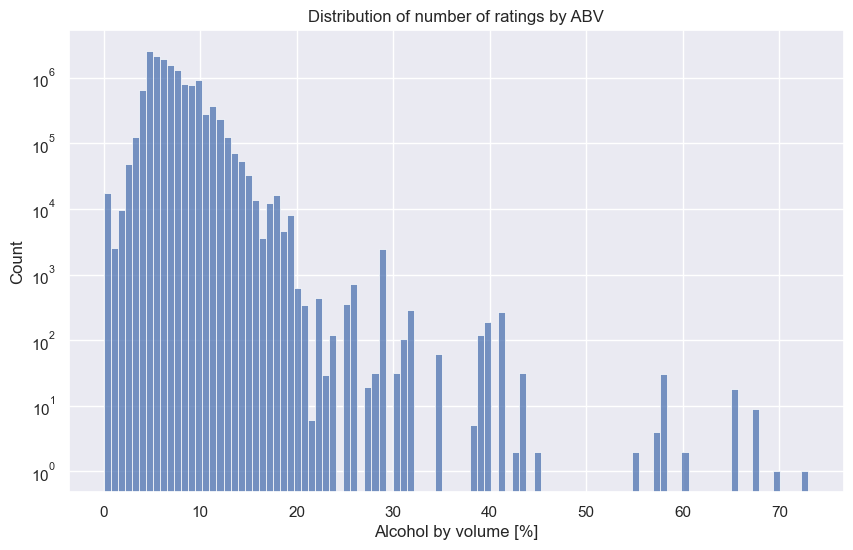

In [90]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='abv', bins=100)
ax.set(yscale='log', title="Distribution of number of ratings by ABV", xlabel="Alcohol by volume [%]")

#### Observations: 
The number of reviews for the beers with ABV > 20% is small and the histogram shows sparse values for high ABV, meaning that there are only a few beers with such ABV. Because of that, we will consider all beers above 20% ABV as one category (as if they had the same ABV).

In [91]:
# Set the maximum ABV (any ABV above this will be considered the same as max_abv) 
max_abv = 20

# Round the ABV
rounded_abv_df = df[['rating', 'eu_na']].copy()
rounded_abv_df['abv'] = df['abv'].round()
rounded_abv_df['abv'] = rounded_abv_df['abv'].apply(lambda x: x if x < max_abv else max_abv)

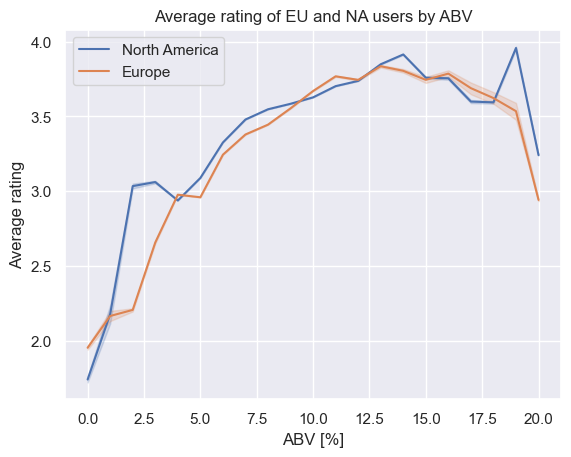

In [92]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=rounded_abv_df, x='abv', y='rating', hue='eu_na', hue_order=hue_order)

ax.get_legend().set_title(None)
ax.set(xlabel="ABV [%]",
       ylabel="Average rating",
       title="Average rating of EU and NA users by ABV")
ax.legend()

#### Observations:
We see that in general, North American users tend to give better ratings than European users for lighter beers with ABV < 10%, and for stronger beers, ABV > 18%. This could point to a difference in taste that depends on the ABV between NA and EU users. This might be also a difference coming from the styles that are consumed. We need to dig deeper into this!

## 4.2 Beer styles

To try to explain the plots above, let's take a look at the different beer styles and their average ABV, as well as their average ratings.
First the average ratings per style:

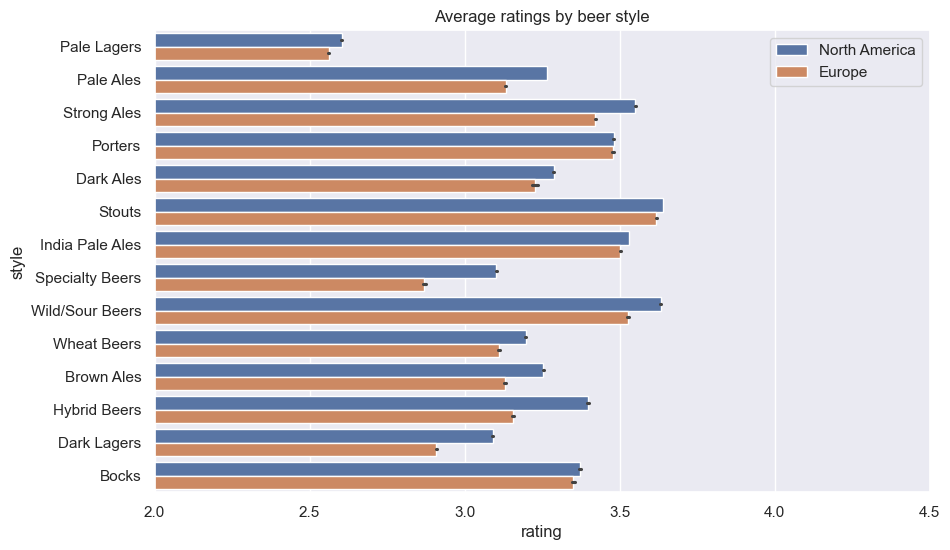

In [93]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='rating', y='style', hue='eu_na', hue_order=hue_order)

ax.get_legend().set_title(None)
ax.set(title='Average ratings by beer style', 
       xlim=(2, 4.5),
       xlabel='Average Rating',
       ylabel='Beer Style'
)
ax.legend(loc='upper right')

And now ABV per style:

[Text(0.5, 1.0, 'Average ABV of each beer style')]

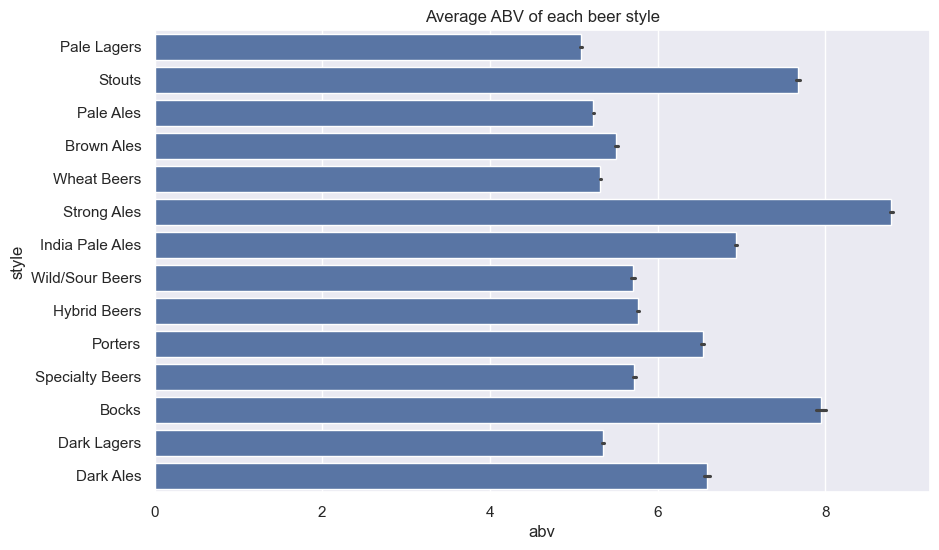

In [94]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=beers_df, x='abv', y='style')
ax.set(title='Average ABV of each beer style',
       xlabel='ABV [%]',
       ylabel='Beer Style')

#### Observations:
We see that some beer styles are significantly stronger than others. If these styles are consumed more frequently on one of the two continents compared to the other, then this could explain some differences in the way ratings are correlated with ABV.

Now let's look at the number of ratings per beer style:

[Text(0.5, 1.0, 'Number of ratings per beer style')]

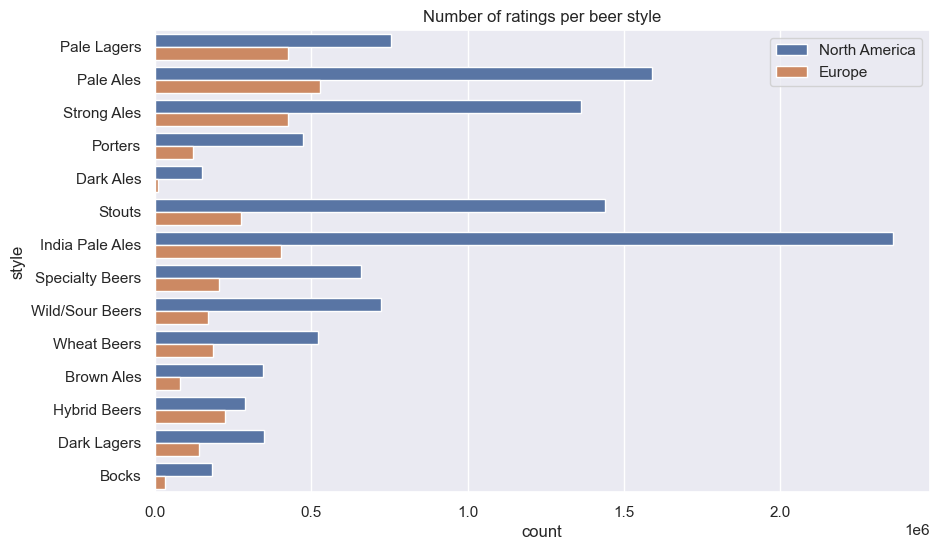

In [95]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, y='style', hue='eu_na', hue_order=hue_order)
ax.get_legend().set_title(None)
ax.legend(loc='upper right')
ax.set(title='Number of ratings per beer style',
       xlabel='Number of ratings',
       ylabel='Beer Style'
)

#### Observations:
TODOOOOOO

#### 3.2 Evolution over time

In the following part, we compare the monthly average ratings of EU and NA users:

[Text(0.5, 1.0, 'Monthly average ratings of Europeans and North Americans')]

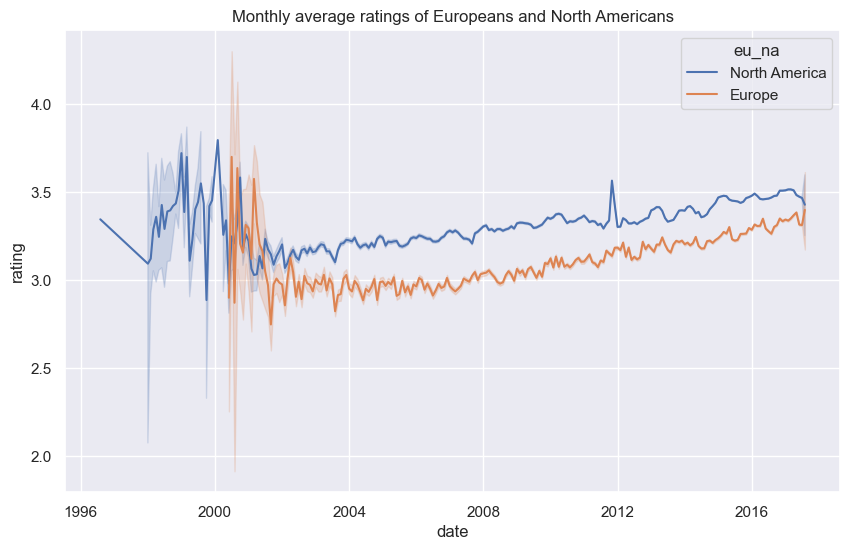

In [96]:
plt.figure(figsize=(10, 6))

ax = sns.lineplot(data=df, x='date', y='rating', hue='eu_na', hue_order=hue_order)
ax.set(title='Monthly average ratings of Europeans and North Americans',
       xlabel='Date',
       ylabel='Average Rating' 
)

#### Observations:
TODOOOOO


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Alcohol by volume [%]'),
 Text(0.5, 1.0, "Monthly average of the ratings' ABV between Europeans and North Americans")]

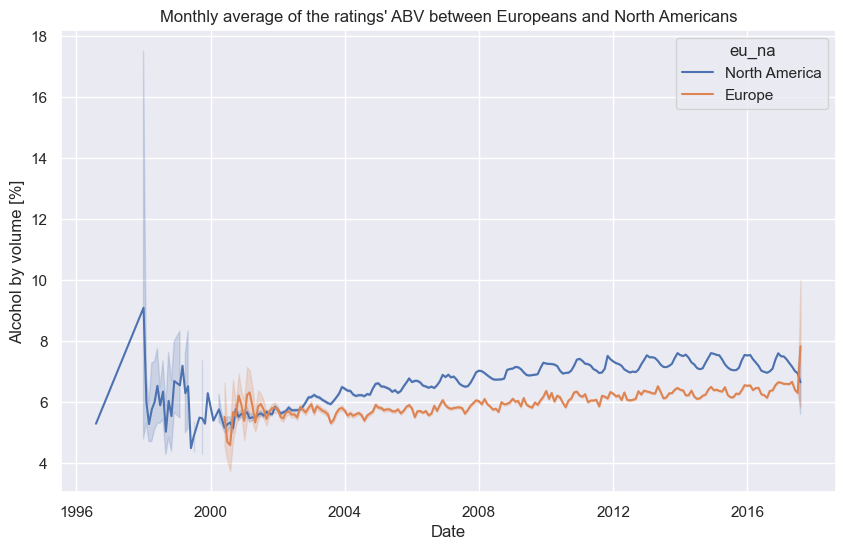

In [97]:
plt.figure(figsize=(10, 6))

ax = sns.lineplot(data=df, x='date', y='abv', hue='eu_na', hue_order=hue_order)

ax.set(xlabel="Date",
       ylabel="Alcohol by volume [%]",
       title="Monthly average of the ratings' ABV between Europeans and North Americans",
       #xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
       ylim=(3.5, 10)
       )

### Observations

TODOOOOOO (modify with seasonality)

- North American consumers consumes stronger beers on average than Europeans
- There is a high aspect of seasonality within ABV, which is more distinct in NA than Europe
- The ABV increases over time, for NA's it started flattening down in the 2010s

Let's now compare differences between alcohol content in styles in NA and EU:

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Alcohol by volume [%]'),
 Text(0.5, 1.0, 'Europe'),
 (10957.0, 17532.0),
 (2.0, 14.0)]

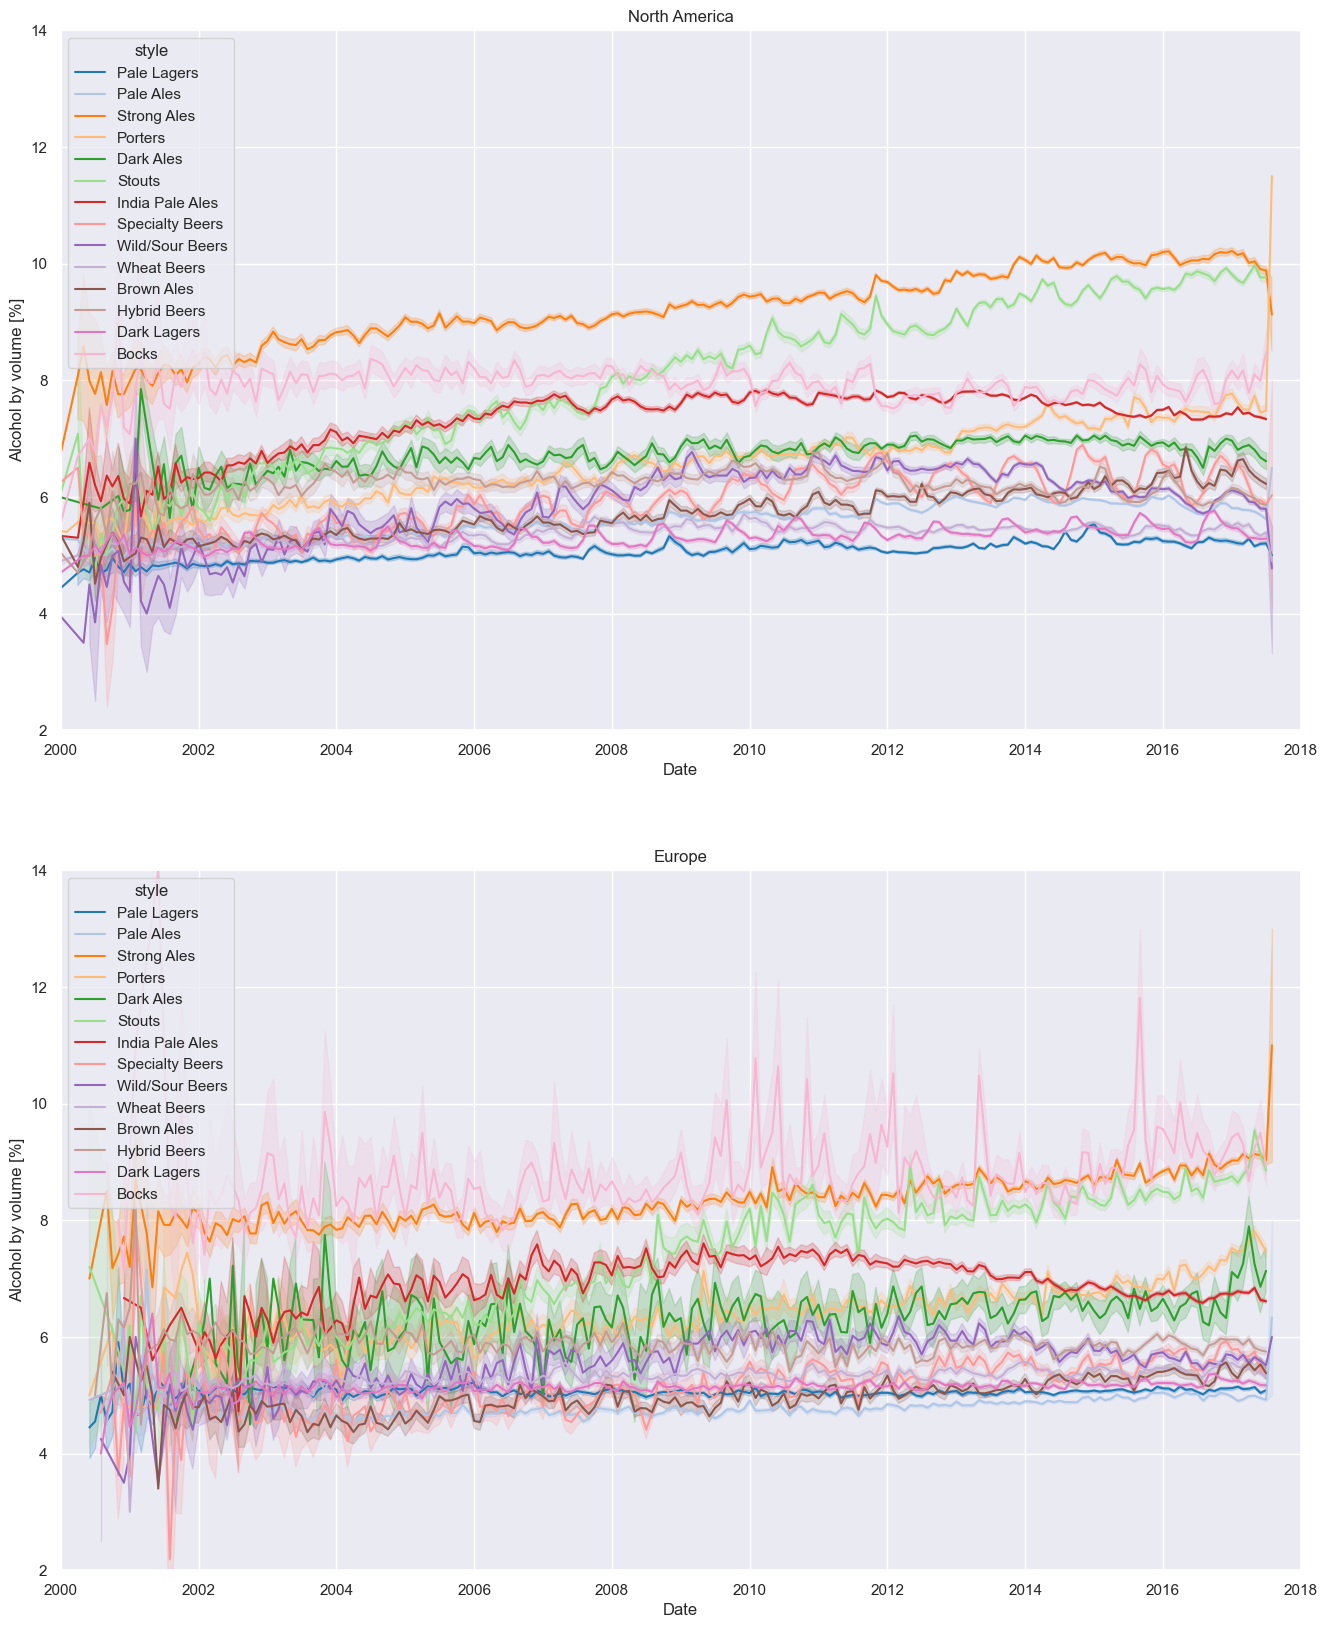

In [99]:
# Only considering RateBeer for now

fig, axes = plt.subplots(2, 1, figsize=(16, 20))

sns.lineplot(data=df.query("eu_na == 'North America'"), x='date', y='abv', hue='style',
             hue_order=hue_order_styles, ax=axes[0], palette='tab20')
sns.lineplot(data=df.query("eu_na == 'Europe'"), x='date', y='abv', hue='style',
             hue_order=hue_order_styles, ax=axes[1], palette='tab20')
axes[0].set(xlabel="Date",
            ylabel="Alcohol by volume [%]",
            title="North America",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(2, 14))

axes[1].set(xlabel="Date",
            ylabel="Alcohol by volume [%]",
            title="Europe",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(2, 14))

#### Observations:
When considering all the beer styles within the data, one observes seasonality within some styles such as Specialty beer or Dark ales. It is also apparent that some beer styles such as Stouts increased drastically in average ABV over time. 
We also notice that some styles seem to differ in ABV on average in both continents.

## Potential issues:
- Larger beer styles might not be 100% correct.
- BeerAdvocate ratings shifting may not be the most accurate (but seems good enough).
- ...